In [1]:
import rasterio as rs
import matplotlib.pyplot as plt
import georaster
from rasterio.plot import show
import cv2
import numpy as np

import geopandas
import os

In [8]:
DATA_PATH = '../data/modis/fire'

In [9]:
files = sorted(os.listdir(DATA_PATH))
files[:3]

['aqua_04.tif', 'aqua_05.tif', 'aqua_06.tif']

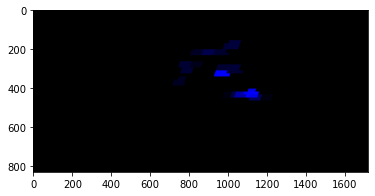

In [10]:
img = cv2.imread(DATA_PATH + '/' + files[2])
plt.imshow(img)

Checking to see if can use difference between consecutive images to gain any info  
Need to model spread of fire as function of previous frame given points of previous fires

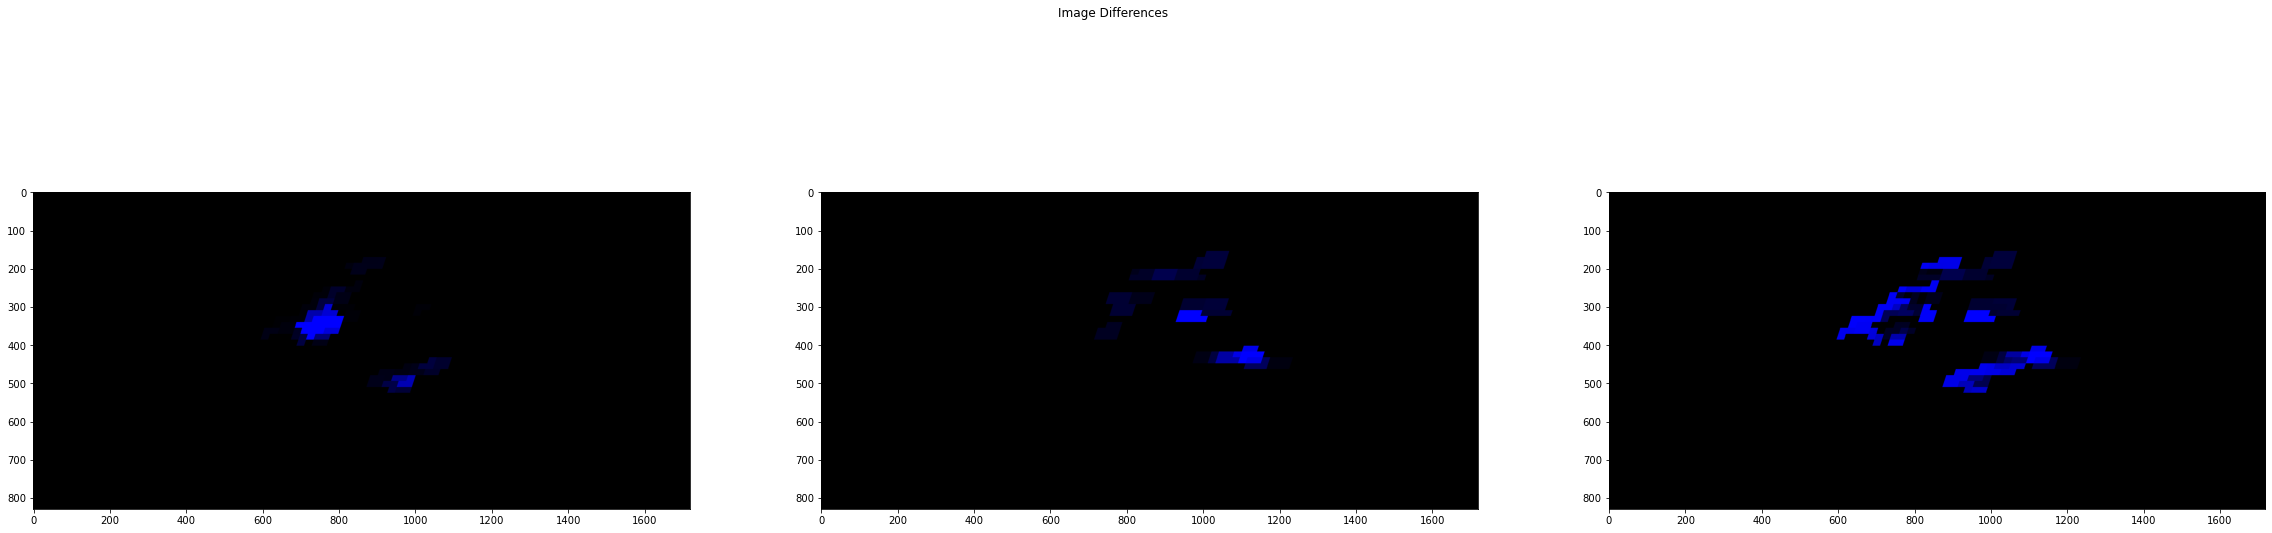

In [5]:
img1, img2  = cv2.imread(os.path.join(DATA_PATH, 'terra_06.tif')), cv2.imread(os.path.join(DATA_PATH, 'aqua_06.tif'))
img_diff = img2-img1

fig, axs = plt.subplots(1,3, figsize=(40, 10))
fig.suptitle('Image Differences')
axs[0].imshow(img1)
axs[1].imshow(img2)
axs[2].imshow(img_diff)

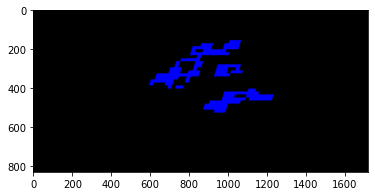

In [6]:
img1 = img1 > 0
img2 = img2 > 0
masked = (img1 ^ img2).astype(int)
masked *= 255
plt.imshow(masked)

### LK Optical Flow
Trying to visualise spread of fire using optical flow  
Intuition is to generate traces (from flow) to highlight direction of fire spread, in addition to thresholding to find areas where fires died down

In [7]:
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

color = "#FF0000"

Ordering all files (integers) so that they are easier to work with in a contiguous array

In [8]:
aqua = {idx: file for idx, file in zip(range(2, 54, 2), files)}
terra = {idx: file for idx, file in zip(range(1, 53, 2), files[26:])}

files_ord = aqua | terra

In [9]:
for i in range(1, len(files_ord.items())+1):
    files_ord[i] = os.path.join(DATA_PATH, files_ord[i])

Not sure why this isn't working, will come back to

In [10]:
# # old_frame = files
# old_frame = cv2.imread(os.path.join(DATA_PATH, files_ord[1]))
# old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
# p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

# mask = np.zeros_like(old_frame)

# for i in range(6, len(files_ord.items())+1):
#     frame = cv2.imread(os.path.join(DATA_PATH, files_ord[i])).astype(float)
# #     frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
#     break

## Centroid Trakcing
Idea: calculate centroid(s) across image frames and measure magnitude and direction of movement across frames to generate motion "vectors"


<font color='red'>Not working for multiple blobs, will try to fix by first finding contours</font>

0.905446191048601


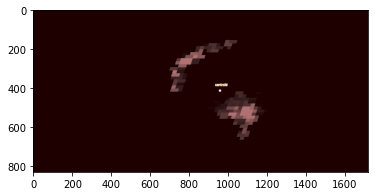

In [11]:
# sanity checking that this works with a single frame
img = cv2.imread(files_ord[8])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)



# convert to binary
ret,thresh = cv2.threshold(img,0.9,255,0)
print(img.mean())
# calculate moments of binary image
M = cv2.moments(thresh)

# calculate x,y coordinate of center
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])

# put text and highlight the center
cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
cv2.putText(img, "centroid", (cX - 25, cY - 25),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

# display the image
plt.imshow(img, cmap='pink')

Following works to calculate multi-blob contour-driven centroids, display is a bit finnicky owing to small size of centre point, but method works

<font color='green'>Move on to calculate movement of contours across frames</font>

3


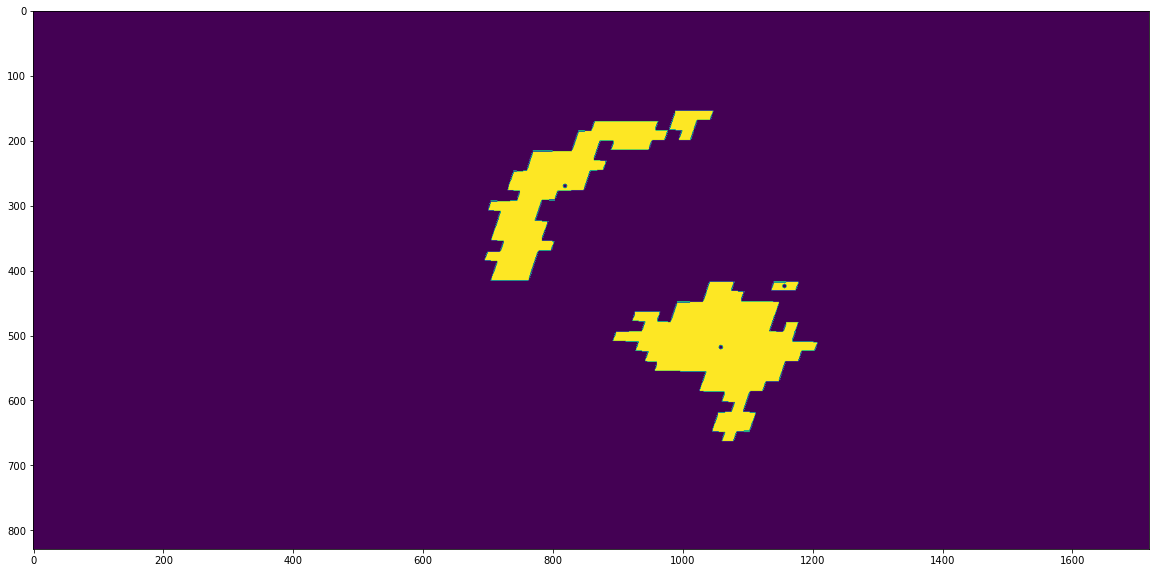

In [12]:
# returns contours, hierarchy
contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_L1)
print(len(contours))
centres = []
for i in range(len(contours)):
    moments = cv2.moments(contours[i])
    centres.append((int(moments['m10']/moments['m00']), int(moments['m01']/moments['m00'])))
    cv2.circle(thresh, centres[-1], 3, (1, 1, 1), -1)
    
for i in range(len(contours)):
    cv2.drawContours(thresh, contours, i, (0, 255, 0))

plt.figure(figsize = (20,10))
plt.imshow(thresh)

Building functions to perform the above operations (greyscale, threshold, contour and centroid)

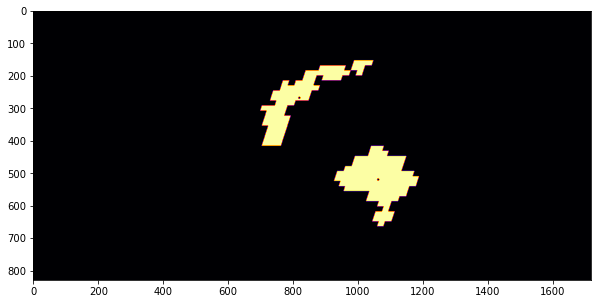

In [13]:
import heapq

def read_to_gray(file_path: str) -> np.array:
    img = cv2.imread(file_path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def threshold_image(img: np.array) -> np.array:
    img_list = list(set(img.flatten()))
    if len(img_list) > 1:
        heap = heapq.heapify(img_list)
        heapq.heappop(img_list)
        second_smallest = heapq.heappop(img_list)
    else:
        second_smallest = 0
    ret, thresh = cv2.threshold(img, second_smallest, 255, 0)
    return thresh


def find_contours(thresh) -> np.array:
    # cv.findContours(image, mode, method[, contours[, hierarchy[, offset]]]) -> contours, hierarchy
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_L1)
    return thresh, contours

def find_moments(thresh: np.array, contours: list) :
    centres = []
    for i in range(len(contours)):
        moments = cv2.moments(contours[i])
        centres.append((int(moments['m10']/moments['m00']), int(moments['m01']/moments['m00'])))
        cv2.circle(thresh, centres[-1], 3, (1, 1, 1), -1)
    
    return thresh, centres

# final sanity check to make sure functions work
img = read_to_gray(files_ord[8])
thresh = threshold_image(img)
thresh, contours = find_contours(thresh)
thresh, centres = find_moments(thresh, contours)

plt.figure(figsize=(10, 10))
plt.imshow(thresh, cmap='inferno')

Using a loop to track centres across frames

In [20]:
contoured = {}

'''
    contoured[idx] {
            'fp': File path to Image,
            'img': Image stored as 32-bit Numpy array, 
            'thresh': Binary thresholded image,
            'contours': Contours in given image,
            'centres': Centroids for each contour    
        }
'''

for key, value in sorted(files_ord.items()):
    img = read_to_gray(value)
    thresh = threshold_image(img)
    thresh, contours = find_contours(thresh)
    thresh, centres = find_moments(thresh, contours)
    
    contoured[key] = {'fp': value, 'img': img, 'thresh': thresh, 'contours': contours, 'centres': centres}

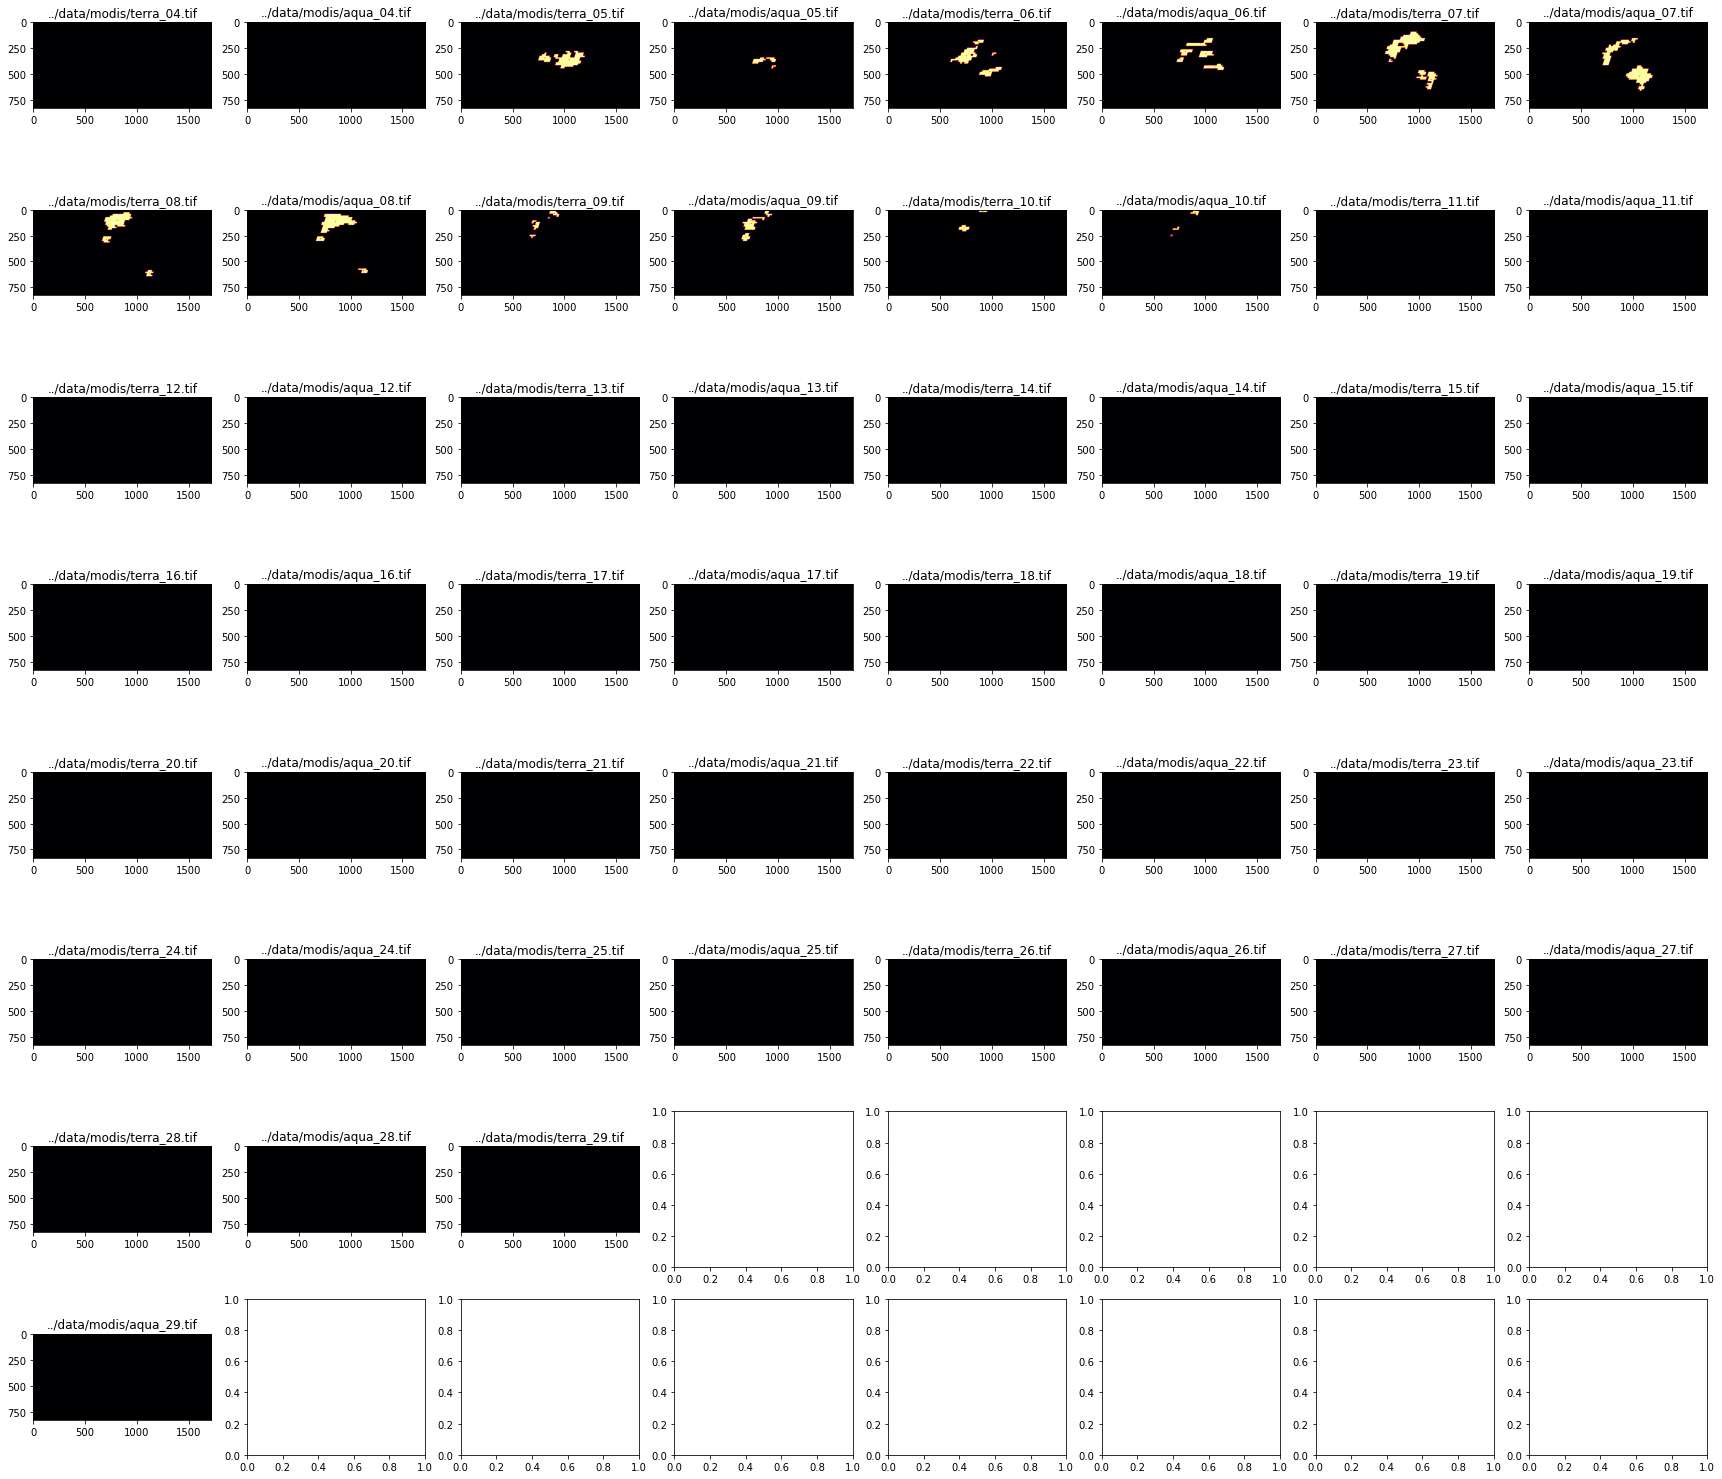

In [15]:
fig, ax = plt.subplots(8, 8, figsize=(30, 27))
key = 1
for i in range(0, 8):
    for j in range(0, 8):
        ax[i][j].imshow(contoured[key]['thresh'], cmap='inferno')
        ax[i][j].title.set_text(contoured[key]['fp'])
        key += 1
        if key >= len(contoured.items()): break
        

<span style="color:green">Above works</span>  
Use images from dates 5th to 11th

- [x] Calculate motion vectors for object centres using time of observation, direction and distance moved


In [36]:
import math
'''
    Finds closest fire centres from two images and return
    paired differences and directions
    
    Returns dictionary indexed by previous centre (px, py) and vector of motion (dx, dy)
'''
def find_closest(prev_centres, cur_centres):
    moved = {}
    for c in cur_centres:
        closest = float('Inf')
        for p in prev_centres:
            centre_distance = math.dist([p[0], p[1]], [c[0],c[1]])
            if centre_distance < closest:
                closest = centre_distance
                
                dx = c[0]-p[0]
                dy = c[1]-p[1]
                moved[p] = (c, (dx, dy))
                
                
    return moved

<h3 style="color:green">Above works</h3>  
<h3 style="color:red">TODO</h3>  

- [ ] Find velocity of motion and relate to other parameters


In [48]:
for idx in range(2, 14):
    prev_centres = contoured[idx]['centres']
    cur_centres = contoured[idx+1]['centres']
    print(find_closest(prev_centres, cur_centres))

{}
{(805, 346): ((857, 366), (52, 20)), (1037, 361): ((953, 429), (-84, 68))}
{(953, 429): ((871, 190), (-82, -239)), (857, 366): ((871, 190), (14, -176))}
{(978, 478): ((948, 201), (-30, -277)), (752, 324): ((802, 287), (50, -37)), (1014, 305): ((948, 201), (-66, -104)), (806, 316): ((802, 287), (-4, -29)), (871, 190): ((948, 201), (77, 11))}
{(1083, 433): ((815, 216), (-268, -217)), (752, 364): ((815, 216), (63, -148)), (802, 287): ((815, 216), (13, -71))}
{(1105, 553): ((820, 269), (-285, -284)), (1018, 509): ((820, 269), (-198, -240)), (714, 372): ((820, 269), (106, -103)), (839, 208): ((820, 269), (-19, 61)), (815, 216): ((820, 269), (5, 53))}
{(1063, 520): ((797, 161), (-266, -359)), (820, 269): ((797, 161), (-23, -108))}
{(1116, 618): ((852, 120), (-264, -498)), (704, 290): ((852, 120), (148, -170)), (808, 108): ((852, 120), (44, 12))}
{(1120, 592): ((896, 40), (-224, -552)), (703, 286): ((896, 40), (193, -246)), (852, 120): ((896, 40), (44, -80))}
{(685, 258): ((900, 43), (215,

New approach, model probability of fire-spread to points outside of fire boundary using geophysical conditions
<p style="color:red">TODO</p> 
<p><input type="checkbox"> Determine set of attributes to use at first</p>
<p><input type="checkbox"> Find suitable model  </p>